In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation
from nltk.corpus import stopwords
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

corpus = pd.read_csv('corpus.csv.gz', compression='gzip')
stopwords = stopwords.words("portuguese")
corpus = corpus[corpus['qual_a_melhor_classificao_para_esse_texto:confidence'] == 1]

In [9]:
n_features = 1600
n_topics = 40
n_top_words = 20

In [28]:
def print_top_words(model, feature_names, n_top_words, stats):
    for topic_idx, topic in enumerate(model.components_):
        if stats.significance[topic_idx] <= 0.05:
            print("Topic #%d (%.5f):" % (topic_idx, stats.significance[topic_idx]))
            print(" ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def diff(x): 
    return (x['diario_mean']) - (x['outro_mean'])

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, strip_accents='unicode',
                                   max_features=n_features,
                                   stop_words=stopwords)
tfidf = tfidf_vectorizer.fit_transform(corpus.content)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, strip_accents='unicode',
                                max_features=n_features,
                                stop_words=stopwords)
tf = tf_vectorizer.fit_transform(corpus.content)

In [29]:
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
data = lda.fit_transform(tf)

topics = pd.DataFrame(data, columns=range(0,n_topics))

topics['class'] = corpus['qual_a_melhor_classificao_para_esse_texto'].values
outro_topics = topics[topics['class']=='outro']
diarios_topics = topics[topics['class']=='diario'].sample(len(outro_topics))

significance = []
for column in list(topics.columns.values):
    if not column == 'class':
        a = diarios_topics[column]
        b = outro_topics[column]
        t, p = wilcoxon(a, b)
        significance.append(p)

stats = pd.DataFrame(data={'significance': significance}, index=range(0,n_topics))

stats['diario_mean'] = diarios_topics.mean(axis=0)
stats['outro_mean'] = outro_topics.mean(axis=0)
stats['diario_std'] = diarios_topics.std(axis=0)
stats['outro_std'] = outro_topics.std(axis=0)

stats['diff'] = stats.apply(diff,axis=1)

size = len(stats[stats['significance'] <= 0.05])
print(str(n_topics) + ' : ' + str(size))

# 35, 38

40 : 38


In [30]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words, stats)

Topic #0 (0.00002):
nao pra ja dia ate aqui tambem bem sao ainda tudo todos so casa sempre fazer porque pouco entao sobre
Topic #1 (0.00867):
advogado policial pare parar sinal diferenca lei carro nao legal favor explicar gente senao conseguir completamente diz lado seguinte sair
Topic #2 (0.00332):
nao sobre by disco menos deus faze saude ja projeto on aqui pra voce pais cirurgia the dar casa tudo
Topic #3 (0.00244):
perda prazo lei membros direitos justica nacional maria pude nao 11 06 publico anos 20 12 decisao publica acao tento
Topic #4 (0.00332):
nao hoje porque tudo dia ja pessoas bom anos pra nada ser fazer aqui bem mim ai sim so mulher
Topic #5 (0.00332):
vida dia tudo cada sempre deus sophia venha certeza faca fazendo ficou coisa festa todos queria momento ano linda 11
Topic #6 (0.00555):
ratos advogado nao sabe dia homem qualquer sao pra primeiro ja contar profissao bem olho sobre ser hoje outros nunca
Topic #7 (0.01389):
garoto 16 joao medico mulher nao cirurgia ate saude h

In [49]:
stats[stats['significance'] <= 0.05]

,significance,diario_mean,outro_mean,diario_std,outro_std,diff
0,0.000025,0.486137,0.307587,0.389265,0.353371,0.178550
1,0.008669,0.000410,0.003939,0.001815,0.048006,-0.003530
2,0.003317,0.000410,0.000238,0.001815,0.000204,0.000171
3,0.002442,0.003184,0.000238,0.038069,0.000204,0.002946
4,0.003317,0.000410,0.000238,0.001815,0.000204,0.000171
5,0.003317,0.000410,0.000238,0.001815,0.000204,0.000171
6,0.005547,0.000410,0.000616,0.001815,0.005169,-0.000206
7,0.013886,0.001052,0.009412,0.007977,0.082383,-0.008360
9,0.004394,0.000410,0.001234,0.001815,0.013660,-0.000825
10,0.007165,0.000613,0.004973,0.003367,0.062369,-0.004361


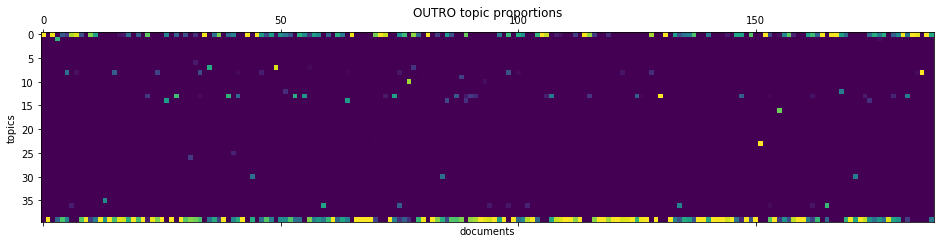

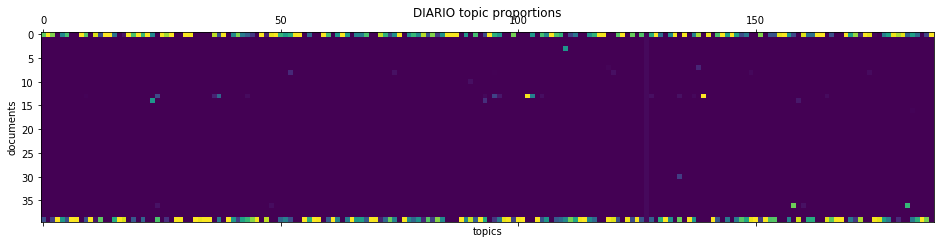

In [91]:
%matplotlib inline

outro_plot = outro_topics.drop('class', axis=1).values
plt.figure()
plt.matshow(np.transpose(outro_plot))   
plt.gca().set_aspect('auto')
plt.title('OUTRO topic proportions')
plt.ylabel('topics')
plt.xlabel('documents')
plt.show()

diario_plot = diarios_topics.drop('class', axis=1).values
plt.figure()
plt.matshow(np.transpose(diario_plot))   
plt.gca().set_aspect(1)
plt.title('DIARIO topic proportions')
plt.xlabel('topics')
plt.ylabel('documents')
plt.show()